# Departamento de produção

## Importação das bibliotecas e base de dados

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skimage import io

import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_all = pd.read_csv('/content/drive/MyDrive/Departamento de manutenção/defect_and_no_defect.csv')

In [4]:
df_all.shape

(12997, 2)

In [5]:
df_all

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [6]:
df_mask = pd.read_csv('/content/drive/MyDrive/Departamento de manutenção/train.csv')

In [7]:
df_mask.shape

(5748, 3)

In [8]:
(df_mask.shape[0] / df_all.shape[0]) * 100

44.22559052088943

In [9]:
df_mask

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [10]:
df_mask['ClassId'].unique()

array([1, 3, 4, 2])

## Exploração e visualização dos dados

In [11]:
df_all['label'].value_counts()

1    7095
0    5902
Name: label, dtype: int64

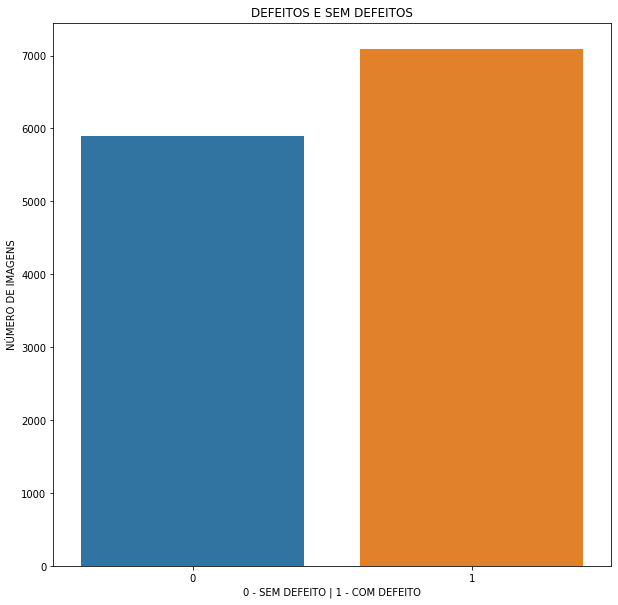

In [12]:
plt.figure(figsize=(10,10))
sns.countplot(x = df_all['label'])
plt.ylabel('NÚMERO DE IMAGENS')
plt.xlabel('0 - SEM DEFEITO | 1 - COM DEFEITO')
plt.title('DEFEITOS E SEM DEFEITOS');

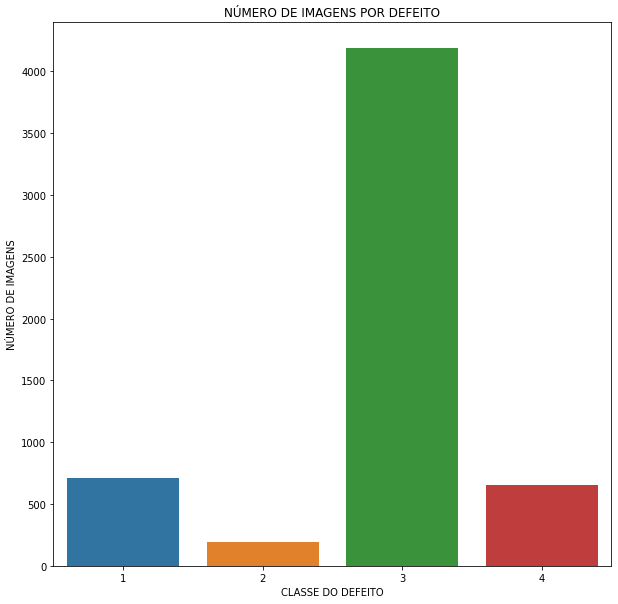

In [13]:
plt.figure(figsize=(10,10))
sns.countplot(x = df_mask['ClassId'])
plt.ylabel('NÚMERO DE IMAGENS')
plt.xlabel('CLASSE DO DEFEITO')
plt.title('NÚMERO DE IMAGENS POR DEFEITO');

In [14]:
df_mask['mask'] = df_mask['ClassId'].map(lambda x:1)

In [15]:
defect_type = df_mask.groupby(['ImageId'])['mask'].sum()
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

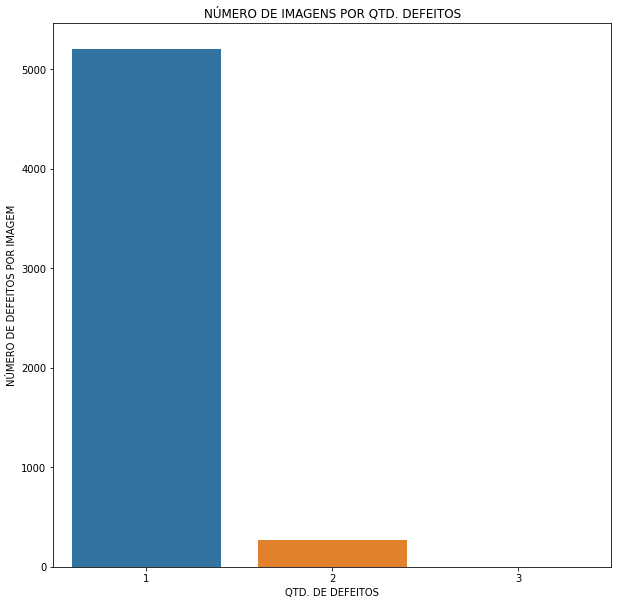

In [16]:
plt.figure(figsize=(10,10))
sns.countplot(x = defect_type)
plt.ylabel('NÚMERO DE DEFEITOS POR IMAGEM')
plt.xlabel('QTD. DE DEFEITOS')
plt.title('NÚMERO DE IMAGENS POR QTD. DEFEITOS');

In [17]:
path_train = '/content/drive/MyDrive/Departamento de manutenção/train_images'

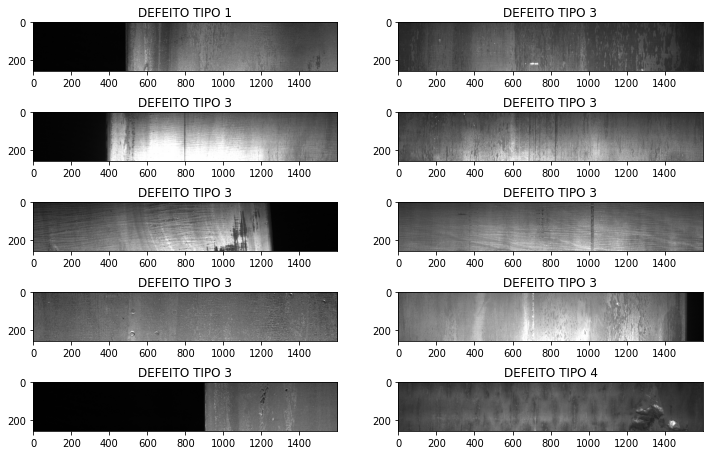

In [18]:
r, c = 0, 0
fig, ax = plt.subplots(5,2, figsize=(12,8))
for i in range(10):
  img = io.imread(os.path.join(path_train, df_mask['ImageId'][i]))
  ax[r][c].set_title('DEFEITO TIPO {}'.format(df_mask['ClassId'][i]))
  ax[r][c].imshow(img);
  c+=1
  if c == 2:
    c = 0
    r+=1

In [19]:
pwd

'/content'

In [20]:
cd /content/drive/MyDrive/Departamento de manutenção

/content/drive/MyDrive/Departamento de manutenção


In [21]:
ls

defect_and_no_defect.csv           ResUNet-steel.json
pm_weights.hdf5                    test.csv
__pycache__/                       train.csv
resnet-50-steel.json               train_images/
resnet-classifier-model.json       utilities.py
resnet-weights.hdf5                weights.hdf5
resunet-segmentation-model.json    weights_seg.hdf5
resunet-segmentation-weights.hdf5


In [22]:
from utilities import rle2mask

In [23]:
df_mask.head()

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1


In [24]:
img.shape

(256, 1600, 3)

In [25]:
img_index = 20
len(df_mask['EncodedPixels'][20])

452

In [26]:
mask=rle2mask(df_mask['EncodedPixels'][img_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

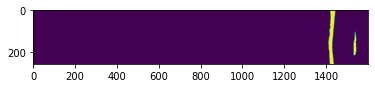

In [27]:
plt.imshow(mask);

(256, 1600, 3)

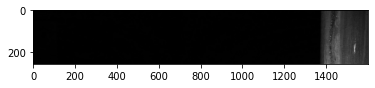

In [28]:
img = io.imread(os.path.join(path_train, df_mask['ImageId'][img_index]))
plt.imshow(img)
img.shape

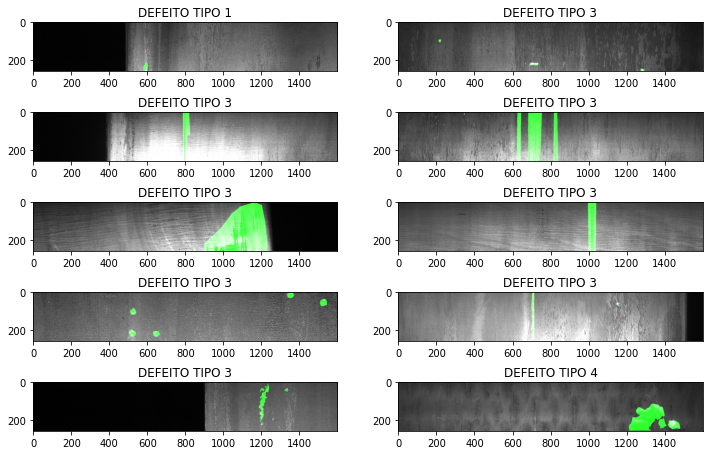

In [29]:
r, c = 0, 0
fig, ax = plt.subplots(5,2, figsize=(12,8))
for i in range(10):
  img = io.imread(os.path.join(path_train, df_mask['ImageId'][i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = rle2mask(df_mask['EncodedPixels'][i], img.shape[0], img.shape[1])
  img[mask == 1,1] = 255

  ax[r][c].imshow(img);  
  ax[r][c].set_title('DEFEITO TIPO {}'.format(df_mask['ClassId'][i]))

  c+=1
  if c == 2:
    c = 0
    r+=1

## Rede neural para prever se há defeito em uma imagem

In [30]:
df_all

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [31]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_all, test_size=0.15, stratify=df_all['label'])
train.shape, test.shape

((11047, 2), (1950, 2))

In [32]:
train.head()

,ImageID,label
4052,9345f1250.jpg,1
5545,c7b88e40a.jpg,1
5460,c4d5657bc.jpg,1
4998,b4efad45e.jpg,1
3544,81aed13bf.jpg,1


In [33]:
test.head()

,ImageID,label
12356,1bad143b0.jpg,0
6389,e5f9a5bb9.jpg,1
7912,dfb34ff29.jpg,0
11044,52b379913.jpg,0
8306,cc00b69e7.jpg,0


In [34]:
from keras_preprocessing.image import ImageDataGenerator

In [35]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [36]:
train_gen = datagen.flow_from_dataframe(dataframe=train, directory=path_train,
                                        x_col='ImageID', y_col='label',
                                        subset='training', batch_size=16,
                                        shuffle=True, class_mode='other',
                                        target_size=(256,256))

Found 9390 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="ImageID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [37]:
val_gen = datagen.flow_from_dataframe(dataframe=train, directory=path_train,
                                        x_col='ImageID', y_col='label',
                                        subset='validation', batch_size=16,
                                        shuffle=True, class_mode='other',
                                        target_size=(256,256))

Found 1656 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="ImageID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [38]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_gen = test_datagen.flow_from_dataframe(dataframe=test, directory=path_train,
                                            x_col='ImageID', y_col=None,
                                            batch_size=16, shuffle=False,
                                            class_mode=None, target_size=(256,256))

Found 1950 validated image filenames.


In [39]:
basemodel = ResNet50(weights='imagenet', include_top=False,
                     input_tensor=Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [40]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [41]:
for layer in basemodel.layers:
  layers.trainable = False

In [42]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten()(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation='sigmoid')(headmodel)

In [43]:
model = Model(inputs=basemodel.input, outputs=headmodel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [44]:
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [45]:
erlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [46]:
chk_pointer = ModelCheckpoint(filepath='pm_weights.hdf5', save_best_only=True)

In [ ]:
hist = model.fit(train_gen, epochs=40, validation_data=val_gen,
                           callbacks=[chk_pointer, erlystopping])

Epoch 1/40
587/587 [==============================] - 2558s 4s/step - loss: 0.8421 - accuracy: 0.6817 - val_loss: 0.6994 - val_accuracy: 0.4438
Epoch 2/40
587/587 [==============================] - 157s 267ms/step - loss: 0.4248 - accuracy: 0.8075 - val_loss: 0.6398 - val_accuracy: 0.6099
Epoch 3/40
587/587 [==============================] - 161s 273ms/step - loss: 0.3567 - accuracy: 0.8474 - val_loss: 10.5902 - val_accuracy: 0.4662
Epoch 4/40
587/587 [==============================] - 161s 273ms/step - loss: 0.3206 - accuracy: 0.8646 - val_loss: 0.4076 - val_accuracy: 0.8134
Epoch 5/40
587/587 [==============================] - 161s 274ms/step - loss: 0.2843 - accuracy: 0.8835 - val_loss: 0.5592 - val_accuracy: 0.8146
Epoch 6/40
587/587 [==============================] - 161s 274ms/step - loss: 0.2506 - accuracy: 0.8987 - val_loss: 0.3755 - val_accuracy: 0.8472
Epoch 7/40
587/587 [==============================] - 161s 274ms/step - loss: 0.2193 - accuracy: 0.9106 - val_loss: 3.8390 - 

In [47]:
model_json = model.to_json()
with open("resnet_cls-model.json","w") as json_file:
  json_file.write(model_json)

## Avaliação da ResNet

In [48]:
with open('/content/drive/MyDrive/Departamento de manutenção/resnet_cls-model.json','r') as json_file:
  json_saved_model = json_file.read()

In [49]:
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": true, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer":

In [50]:
model = tf.keras.models.model_from_json(json_saved_model)
model.load_weights('/content/drive/MyDrive/Departamento de manutenção/pm_weights.hdf5')
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [51]:
test_pred = model.predict(test_gen, verbose=True)

122/122 [==============================] - 955s 8s/step


In [52]:
test_pred

array([[0.04249598],
       [0.99979395],
       [0.00159763],
       ...,
       [0.00759276],
       [0.0599683 ],
       [0.96881783]], dtype=float32)

In [53]:
predict = []
for i in test_pred:
  if i < 0.01:
    predict.append(0)
  else:
    predict.append(1)
predict = np.array(predict)
len(predict)

1950

In [54]:
predict

array([1, 1, 0, ..., 0, 1, 1])

In [55]:
test.label

12356    0
6389     1
7912     0
11044    0
8306     0
        ..
2240     1
10256    0
8977     0
12159    0
710      1
Name: label, Length: 1950, dtype: int64

In [56]:
original = np.asarray(test.label)
len(original)

1950

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(original, predict)

0.8071794871794872

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, predict)
cm

array([[ 515,  371],
       [   5, 1059]])

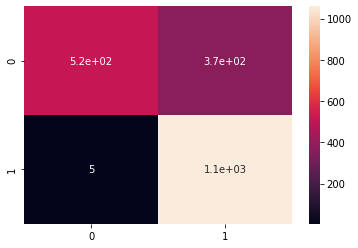

In [59]:
sns.heatmap(cm, annot=True);

In [60]:
from sklearn.metrics import classification_report
print(classification_report(original, predict))

              precision    recall  f1-score   support

           0       0.99      0.58      0.73       886
           1       0.74      1.00      0.85      1064

    accuracy                           0.81      1950
   macro avg       0.87      0.79      0.79      1950
weighted avg       0.85      0.81      0.80      1950



## Rede neural para segmentação de imagens com ResUnet

- https://arxiv.org/abs/1505.04597 
- https://arxiv.org/abs/1904.00592
- https://towardsdatascience.com/introduction-to-u-net-and-res-net-for-image-segmentation-9afcb432ee2f

In [61]:
df_mask

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(df_mask, test_size=0.2)
X_train.shape, X_val.shape

((4598, 4), (1150, 4))

In [63]:
train_ids = list(X_train['ImageId'])
train_cls = list(X_train['ClassId'])
train_rle = list(X_train['EncodedPixels'])

In [64]:
len(train_ids), len(train_ids), len(train_rle)

(4598, 4598, 4598)

In [65]:
print(train_ids[:5])
print(train_cls[:5])
print(train_rle[:5])

['f14cec989.jpg', '139b7e692.jpg', 'd4935dbfe.jpg', 'fb38bb7bf.jpg', 'd9d9f2b25.jpg']
[3, 4, 3, 3, 3]
['14084 22 14340 64 14596 106 14852 148 15108 190 15364 232 15620 253 15876 253 16132 253 16388 253 16644 253 16900 253 17156 253 17412 253 17668 253 17924 253 18180 253 18436 253 18691 254 18947 254 19203 254 19459 254 19715 254 19971 254 20227 254 20483 254 20739 254 20995 254 21251 254 21507 254 21763 254 22019 254 22275 254 22531 254 22787 254 23043 254 23299 254 23555 254 23811 254 24067 254 24323 254 24579 254 24835 254 25091 254 25347 254 25603 254 25859 254 26115 254 26371 254 26627 254 26883 254 27139 254 27394 255 27650 255 27906 255 28162 255 28418 255 28674 255 28930 255 29186 255 29442 255 29698 255 29954 255 30210 255 30466 255 30722 255 30978 255 31234 255 31490 255 31789 212 32130 127 32470 43 59393 231 59649 231 59905 231 60161 231 60417 231 60673 231 60929 231 61185 230 61442 229 61698 229 61954 229 62210 229 62466 229 62722 190 62978 114 63234 38 80900 9 81156 26 814

In [66]:
val_ids = list(X_val['ImageId'])
val_cls = list(X_val['ClassId'])
val_rle = list(X_val['EncodedPixels'])

In [67]:
len(val_ids), len(val_ids), len(val_rle)

(1150, 1150, 1150)

In [77]:
from utilities import DataGenerator

In [78]:
train_generator = DataGenerator(train_ids, train_cls, train_rle, path_train)
val_generator = DataGenerator(val_ids, val_cls, val_rle, path_train)

In [70]:
def resblock(X, f):

  X_copy = X

  # he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
  X = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  # padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
  # padding: https://wandb.ai/krishamehta/seo/reports/Difference-Between-SAME-and-VALID-Padding-in-TensorFlow--VmlldzoxODkwMzE
  X = Conv2D(f, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
  X = BatchNormalization()(X)

  X_copy = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  return X

In [71]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])
  return merge

In [72]:
input_shape = (256,256,1)
X_input = Input(input_shape)

# Estágio 1
conv1_in = Conv2D(16,3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size=(2,2))(conv1_in)

# Estágio 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size=(2,2))(conv2_in)

# Estágio 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size=(2,2))(conv3_in)

# Estágio 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size=(2,2))(conv4_in)

# Estágio 5
conv5_in = resblock(pool_4, 256)

# Up 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Up 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Up 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Up 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# FINAL
output = Conv2D(4, (1,1), padding='same', activation='sigmoid')(up_4)
model_seg = Model(inputs=X_input, outputs=output)

## Loss function
 
- Precisamos de uma função de erro personalizada para treinar a ResUnet
- Mais informações: https://arxiv.org/abs/1810.07842
- Fonte: https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

In [73]:
pwd

'/content/drive/My Drive/Departamento de manutenção'

In [74]:
from utilities import focal_tversky, tversky_loss, tversky

In [79]:
adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

In [82]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
chk_pointer = ModelCheckpoint(filepath='resunet-seg_pm-weights.hdf5', verbose=1, save_best_only=True)

In [83]:
hist = model_seg.fit(train_generator, epochs=40, validation_data=val_generator,
                     callbacks=[chk_pointer, earlystopping])

Epoch 1/40
287/287 [==============================] - 1929s 7s/step - loss: 0.9371 - tversky: 0.0828 - val_loss: 0.8941 - val_tversky: 0.1384

Epoch 00001: val_loss improved from inf to 0.89406, saving model to resunet-seg_pm-weights.hdf5
Epoch 2/40
287/287 [==============================] - 146s 509ms/step - loss: 0.7416 - tversky: 0.3259 - val_loss: 0.7320 - val_tversky: 0.3392

Epoch 00002: val_loss improved from 0.89406 to 0.73201, saving model to resunet-seg_pm-weights.hdf5
Epoch 3/40
287/287 [==============================] - 139s 483ms/step - loss: 0.6389 - tversky: 0.4478 - val_loss: 0.6512 - val_tversky: 0.4335

Epoch 00003: val_loss improved from 0.73201 to 0.65118, saving model to resunet-seg_pm-weights.hdf5
Epoch 4/40
287/287 [==============================] - 138s 481ms/step - loss: 0.6099 - tversky: 0.4810 - val_loss: 0.5943 - val_tversky: 0.4993

Epoch 00004: val_loss improved from 0.65118 to 0.59432, saving model to resunet-seg_pm-weights.hdf5
Epoch 5/40
287/287 [======

In [ ]:
model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

## Avaliação ResUnet

In [84]:
with open('/content/drive/MyDrive/Departamento de manutenção/resunet-segmentation-model.json') as json_file:
  json_saved_model = json_file.read()

In [85]:
json_saved_model

'{"class_name": "Model", "config": {"name": "model_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_2"}, "name": "input_2", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 2.0, "mode": "fan_in", "distribution": "truncated_normal", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv2d", "inbound_nodes": [[["input_2", 0, 0, {}]]]}, {"class_name": "BatchNormalization", "config": {"name": "batc

In [86]:
model_seg = tf.keras.models.model_from_json(json_saved_model)
model_seg.load_weights('/content/drive/MyDrive/Departamento de manutenção/resunet-seg_pm-weights.hdf5')
adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

In [87]:
df_test = pd.read_csv('/content/drive/MyDrive/Departamento de manutenção/test.csv')
df_test

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [88]:
from utilities import prediction

In [89]:
image_id, defect_type, mask = prediction(df_test, model, model_seg)

In [91]:
df_pred = pd.DataFrame({'ImageId': image_id,
                        'EncodedPixels':mask,
                        'ClassId':defect_type})

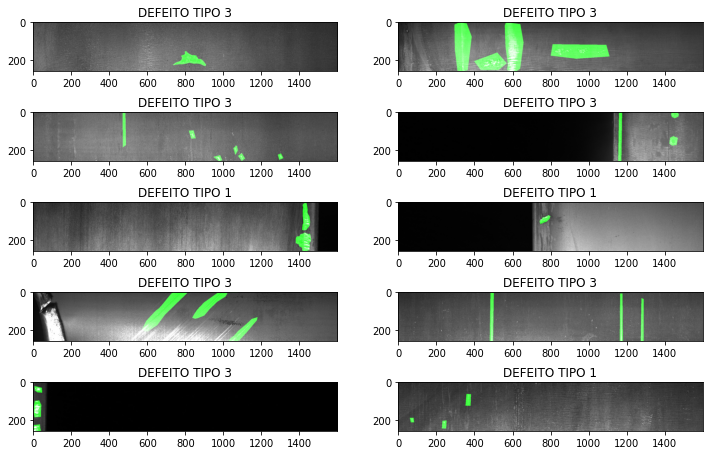

In [92]:
r, c = 0, 0
fig, ax = plt.subplots(5,2, figsize=(12,8))
for i in range(10):
  img = io.imread(os.path.join(path_train, df_test['ImageId'][i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = rle2mask(df_test['EncodedPixels'][i], img.shape[0], img.shape[1])
  img[mask == 1,1] = 255  

  ax[r][c].imshow(img);  
  ax[r][c].set_title('DEFEITO TIPO {}'.format(df_test['ClassId'][i]))

  c+=1
  if c == 2:
    c = 0
    r+=1

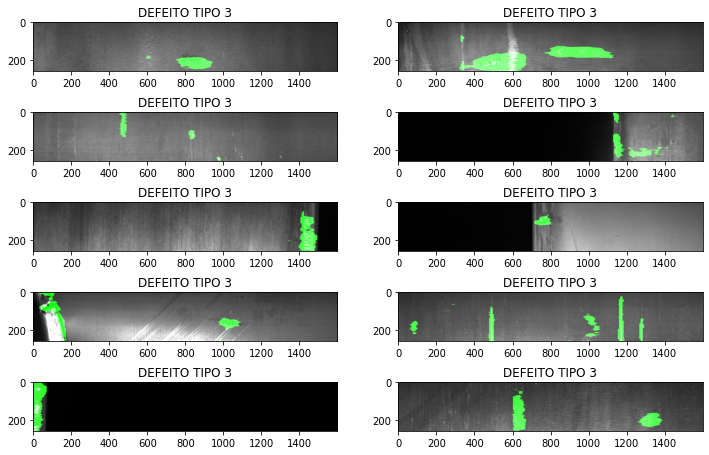

In [93]:
r, c = 0, 0
fig, ax = plt.subplots(5,2, figsize=(12,8))
for i in range(10):
  img = io.imread(os.path.join(path_train, df_pred['ImageId'][i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = rle2mask(df_pred['EncodedPixels'][i], img.shape[0], img.shape[1])
  img[mask == 1,1] = 255  

  ax[r][c].imshow(img);  
  ax[r][c].set_title('DEFEITO TIPO {}'.format(df_pred['ClassId'][i]))

  c+=1
  if c == 2:
    c = 0
    r+=1